### Загрузка данных

In [0]:
!!pip install --upgrade --force-reinstall --no-deps kaggle

['Processing /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674/kaggle-1.5.6-cp36-none-any.whl',
 'Installing collected packages: kaggle',
 '  Found existing installation: kaggle 1.5.6',
 '    Uninstalling kaggle-1.5.6:',
 '      Successfully uninstalled kaggle-1.5.6',
 'Successfully installed kaggle-1.5.6']

In [0]:
import os
user = ''
key = ''
 
if '.kaggle' not in os.listdir('/root'):
    !mkdir ~/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 666 /root/.kaggle/kaggle.json
with open('/root/.kaggle/kaggle.json', 'w') as f:
    f.write('{"username":"%s","key":"%s"}' % (user, key))
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
!kaggle competitions download -c tensorflow-speech-recognition-challenge

tensorflow-speech-recognition-challenge.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
!unzip tensorflow-speech-recognition-challenge.zip

Archive:  tensorflow-speech-recognition-challenge.zip
replace link_to_gcp_credits_form.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Распаковка данных | Unpack data files

In [0]:
!pip install pyunpack
!pip install patool

In [0]:
from pyunpack import Archive
import os
import shutil

Archive('train.7z').extractall('/content/')
Archive('sample_submission.7z').extractall('/content/')

# Data distribution

In [0]:
# Loading the trainig Input file.
TRAIN_AUDIO_PATH = "/content/train/audio/"

In [0]:
print("Total classes:\n",
      len(os.listdir(TRAIN_AUDIO_PATH)),
      "\n",
      
      os.listdir(TRAIN_AUDIO_PATH))

Total classes:
 31 
 ['go', 'marvin', 'eight', 'house', 'nine', 'happy', 'off', 'five', 'bed', 'two', 'bird', 'stop', 'up', 'no', 'sheila', 'right', 'down', 'tree', '_background_noise_', 'left', 'on', 'dog', 'one', 'four', 'three', 'six', 'seven', 'wow', 'yes', 'cat', 'zero']


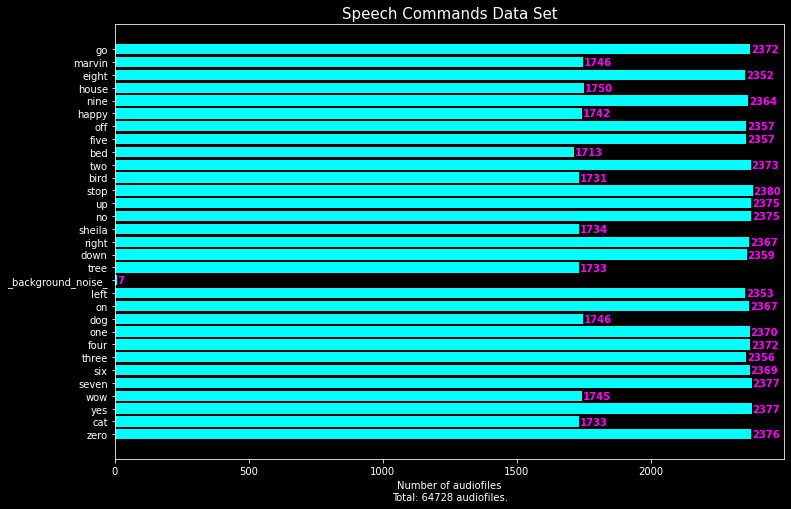

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
import numpy as np

plt.style.use("dark_background")

#  data
def get_data_distribution(data_path):
    labels = os.listdir(data_path)
    num_labels_data = [len(os.listdir(data_path + l)) 
                        for l in labels]
    num_all_data = sum(num_labels_data)

    return labels, num_labels_data, num_all_data

labels, num_labels_data, num_all_data = get_data_distribution(TRAIN_AUDIO_PATH)

# plot
fig, ax = plt.subplots(figsize=(12, 8))

ax.barh(labels, num_labels_data, align='center', color='aqua', ecolor='white')
ax.set_yticks(labels)
ax.set_yticklabels(labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel(f'Number of audiofiles\nTotal: {num_all_data} audiofiles.')
ax.set_title('Speech Commands Data Set', fontsize=15)
for i, v in enumerate(num_labels_data):
    ax.text(v + 3, i + .25, str(v), color="fuchsia", fontweight='bold')

plt.show()
plt.savefig("data_distribution.png", bbox_inches='tight', 
            pad_inches=0.2, transparent=True)



# Let's see on waveforms and spectogramms of audio files

In [0]:
!pip install librosa

In [0]:
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)




def plot_wave_and_specgram(title, fn, data_type="waveform", 
                           columns=2, rows=16):
    
    fig = plt.figure(figsize=(16, 10))

    inds = np.random.randint(low=1, high=7, size=len(labels))
    for i, (label, ind) in enumerate(zip(labels, inds)):
        
        # data
        wave_path = os.listdir(TRAIN_AUDIO_PATH+label)[ind]
        # if readme.md, than continue
        if "".join(list(wave_path)[-4:]) != ".wav":
            continue

        samples, sample_rate = librosa.load(TRAIN_AUDIO_PATH+label+"/"+wave_path,
                                            sr=None)
        # plot
        ax = fig.add_subplot(rows, columns, i+1)
        if data_type == "waveform":
            colors = random.choices(list(mcolors.CSS4_COLORS.keys()),
                                k=len(labels))
            plt.plot(samples, label=label, color=colors[i]);
            plt.legend();
        elif data_type == "specgram":
            freqs, times, spectrogram = log_specgram(samples, sample_rate)
            ax.set_title(label);
            ax.imshow(spectrogram.T, aspect='auto',
                   extent=[times.min(), times.max(), freqs.min(), freqs.max()])
            plt.axis("off")
    
    plt.suptitle(title, 
                 fontsize=15, 
                 fontweight='bold')
    
    plt.savefig(fn, bbox_inches='tight', 
                    pad_inches=0.2, transparent=True)

    return plt.show()

No handles with labels found to put in legend.


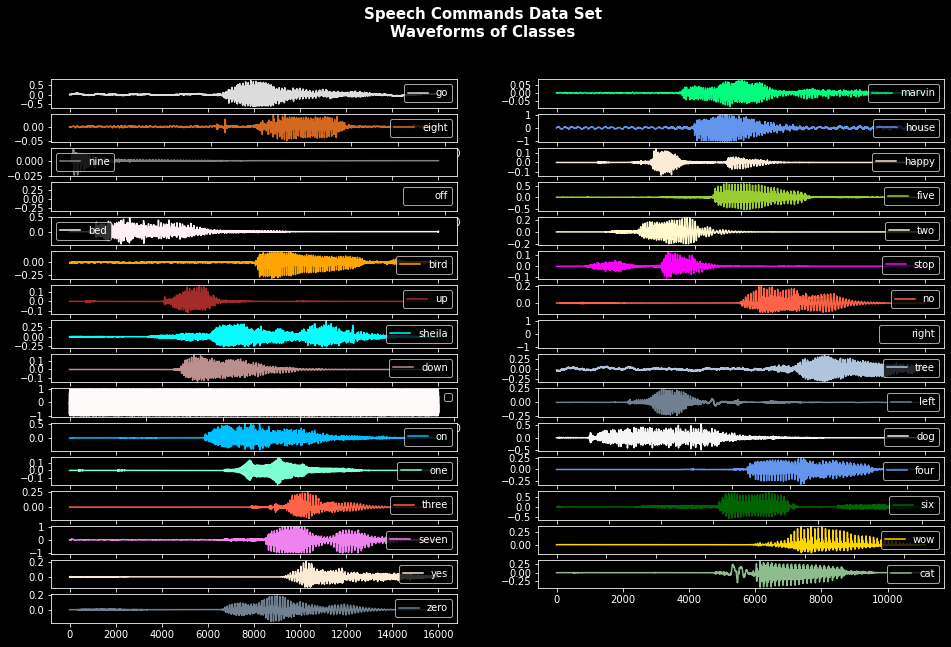

In [0]:
plot_wave_and_specgram(title='Speech Commands Data Set\nWaveforms of Classes',
                       fn="waves_of_classes.png",
                       data_type="waveform")

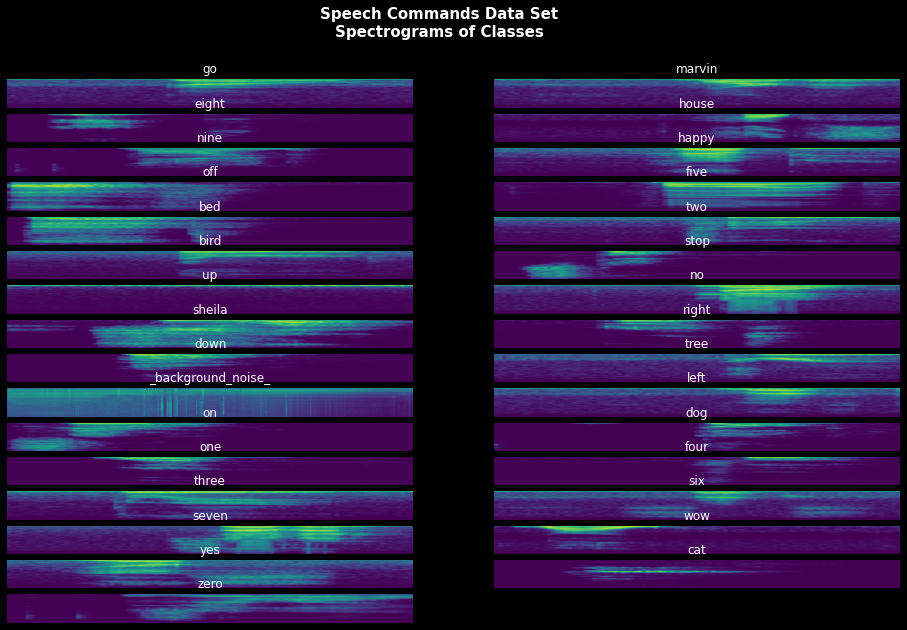

In [0]:
plot_wave_and_specgram(title='Speech Commands Data Set\nSpectrograms of Classes',
                       fn="specgram_of_classes.png",
                       data_type="specgram")

# Play audio files

In [0]:
from IPython.display import Audio


idx = int(np.random.randint(low=0, high=len(labels)-1, size=1))
path_to_file = TRAIN_AUDIO_PATH + labels[idx]
fn = np.random.choice(os.listdir(path_to_file))
print("Label: ", labels[idx],"\n")
full_path = path_to_file + "/" + fn
samples, sample_rate = librosa.load(full_path)
Audio(data=samples, rate=sample_rate)

Label:  five 

